Chatbot (Without Frontend) with Sentiment Analysis using LSTM | Aayush Amritesh (aayushamritesh@gmail.com)

In [7]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk

nltk.download('stopwords')
sns.set(style="darkgrid")
%matplotlib inline

import re
import string
from nltk.corpus import stopwords
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import f1_score, precision_score, recall_score
import pickle

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
#Cleaning the text using NLP and regular expressions
def text_cleaning(text):
    text = re.sub(r'https?://\S+|www\.\S+', 'URL', text)
    text = re.sub(r'<.*?>', '', text)
    text = ''.join([char for char in text if char in string.printable])
    text = re.sub(r'@\S+', 'USER', text)
    table = str.maketrans('', '', string.punctuation)
    text = text.translate(table)
    text = ' '.join([word for word in text.split() if word not in stopwords.words("english")])
    return text

In [9]:
# Fetching reddit data
data = pd.read_csv("Reddit_Data.csv")
# Renaming column
data.rename({'clean_comment':'clean_text'}, axis=1, inplace=True)
data.head()

,clean_text,category
0,family mormon have never tried explain them t...,1.0
1,buddhism has very much lot compatible with chr...,1.0
2,seriously don say thing first all they won get...,-1.0
3,what you have learned yours and only yours wha...,0.0
4,for your own benefit you may want read living ...,1.0


In [10]:
# Checking datatypes (shape of data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33194 entries, 0 to 33193
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   clean_text  33104 non-null  object 
 1   category    33193 non-null  float64
dtypes: float64(1), object(1)
memory usage: 518.8+ KB


In [11]:
# Checking Statistical Summary of data
data.describe(include='all')

,clean_text,category
count,33104,33193.000000
unique,32815,NaN
top,,NaN
freq,100,NaN
mean,NaN,0.206248
std,NaN,0.783815
min,NaN,-1.000000
25%,NaN,0.000000
50%,NaN,0.000000
75%,NaN,1.000000


In [12]:
# Checking null values
print(data.isnull().sum())
print()

# Removing null values
data.dropna(inplace=True)
print(data.isnull().sum())

clean_text    90
category       1
dtype: int64

clean_text    0
category      0
dtype: int64


In [13]:
# Checking duplicated values
print(data.duplicated().sum())
print()

# Removing duplicated values
data.drop_duplicates(inplace=True)
data.duplicated().sum()

289



0

In [14]:
# Cleaning text using NLP/Regular expression techniques i.e.,
# Removing URLs, Removing tags, Removing non-ASCII characters, Removing mentions (@username), Removing all punctuations, Removing English stopwords
data["clean_text"] = data["clean_text"].apply(text_cleaning)
data.head()

,clean_text,category
0,family mormon never tried explain still stare ...,1.0
1,buddhism much lot compatible christianity espe...,1.0
2,seriously say thing first get complex explain ...,-1.0
3,learned want teach different focus goal wrappi...,0.0
4,benefit may want read living buddha living chr...,1.0


In [15]:
# Renaming the category
mapping = {0: 'Neutral', 1: 'Positive', -1: 'Negative'}
data['category'] = data['category'].map(mapping)
data.head()

,clean_text,category
0,family mormon never tried explain still stare ...,Positive
1,buddhism much lot compatible christianity espe...,Positive
2,seriously say thing first get complex explain ...,Negative
3,learned want teach different focus goal wrappi...,Neutral
4,benefit may want read living buddha living chr...,Positive


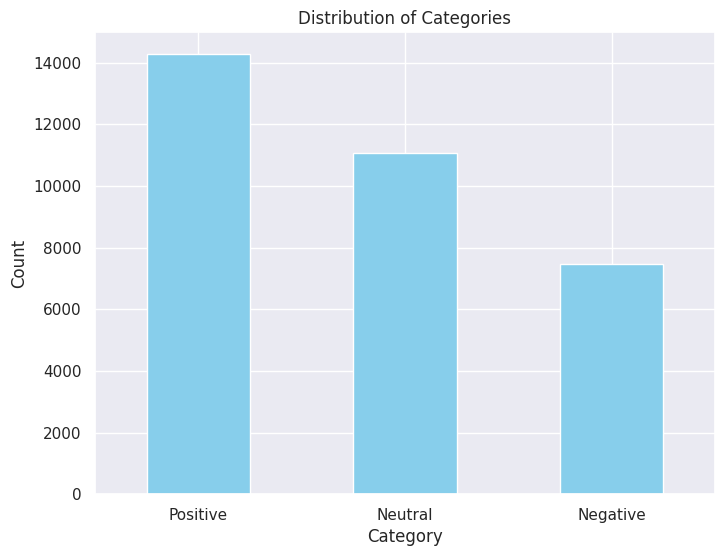

In [16]:
# Checking the distribution of categories
category_counts = data['category'].value_counts()
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [17]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['clean_text'], data['category'], test_size=0.2, random_state=42)

In [18]:
# Encoding the target labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# Checking the mapping
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Class Mapping:")
for class_label, encoded_value in class_mapping.items():
    print(f"{class_label}: {encoded_value}")

Class Mapping:
Negative: 0
Neutral: 1
Positive: 2


In [19]:
# Tokenizing and padding the text data
max_words = 10000
max_sequence_length = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_sequence = tokenizer.texts_to_sequences(X_train)
X_test_sequence = tokenizer.texts_to_sequences(X_test)
X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train_sequence, maxlen=max_sequence_length)
X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test_sequence, maxlen=max_sequence_length)
# Saving the tokenizer for future use
tokenizer_filename = 'tokenizer.pkl'
with open(tokenizer_filename, 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

In [20]:
# Building and Evaluating the model

# Hyperparameters
embedding_dim = 100
batch_size = 64
epochs = 10

# Building the LSTM model
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_sequence_length))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# Compiling & training
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_padded, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

# Evaluation on Test data
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test, verbose=1)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

# Predictions on Test data
y_test_pred = model.predict(X_test_padded)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Calculate additional metrics
f1 = f1_score(y_test, y_test_pred_classes, average='weighted')
precision = precision_score(y_test, y_test_pred_classes, average='weighted')
recall = recall_score(y_test, y_test_pred_classes, average='weighted')
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

Epoch 1/10
370/370 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.6206 - loss: 0.8539 - val_accuracy: 0.8275 - val_loss: 0.4648
Epoch 2/10
370/370 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8927 - loss: 0.3247 - val_accuracy: 0.8549 - val_loss: 0.4098
Epoch 3/10
370/370 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9331 - loss: 0.2253 - val_accuracy: 0.8481 - val_loss: 0.4532
Epoch 4/10
370/370 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9530 - loss: 0.1695 - val_accuracy: 0.8545 - val_loss: 0.4796
Epoch 5/10
370/370 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9637 - loss: 0.1369 - val_accuracy: 0.8423 - val_loss: 0.5483
Epoch 6/10
370/370 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9717 - loss: 0.1047 - val_accuracy: 0.8462 - val_loss: 0.5983
Epoch 7/10
370/370 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9763 - loss: 0.0899 - val_accuracy: 0.8359 - val_loss: 0.7288
Epoch 8/10
370/370 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9780 - loss: 0.0798 - val_accuracy:

In [21]:
# Saving the model to a file
model.save('Aayush_Amritesh.h5')

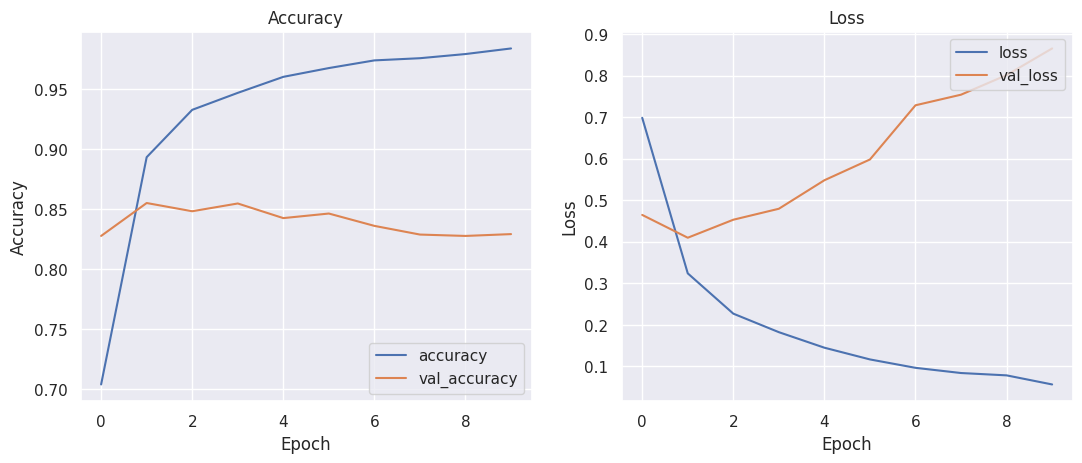

In [22]:
# Plotting training and testing curves
default_size = plt.rcParams['figure.figsize']
fig = plt.figure(figsize=[default_size[0] * 2, default_size[1]])

fig.add_subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label = 'accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')

fig.add_subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(loc='upper right')
plt.show()

In [27]:
# Execution and Testing the model
user_input = input("Enter your message :")
user_sequences = tokenizer.texts_to_sequences([user_input])
user_padded = tf.keras.preprocessing.sequence.pad_sequences(user_sequences, maxlen=max_sequence_length)

from keras.models import load_model
loaded_model = load_model('Aayush_Amritesh.h5')
class_mapping={
0:'Negative',
1:'Neutral',
2:'Positive'}
# Make predictions on user input
user_predictions = loaded_model.predict(user_padded)
# Convert predictions to class labels (assuming it's a classification task)
user_pred_classes = np.argmax(user_predictions, axis=1)
# Print the predicted class
print(f'Predicted Class: {class_mapping[user_pred_classes[0]]}')

Enter your message :do you work dont interfare in my work you stupid baby love


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Predicted Class: Negative
